In [86]:
# library(tidyverse)
# library(stats)
# library(readxl)
# library(forecast)
library(quantmod)
library(ggplot2)
library(tseries)


In [76]:
HomePrice = read.csv("./US_National_Home_price.csv")

HomePrice = xts(HomePrice, order.by=as.Date(HomePrice$DATE, format="%Y-%m-%d")) 
storage.mode(HomePrice) = "numeric"
HomePrice$DATE = NULL

Warning message in storage.mode(HomePrice) = "numeric":
“NAs introduced by coercion”

In [112]:
head(HomePrice)

           CSUSHPINSA
1987-01-01     63.753
1987-02-01     64.153
1987-03-01     64.490
1987-04-01     64.995
1987-05-01     65.570
1987-06-01     66.238

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


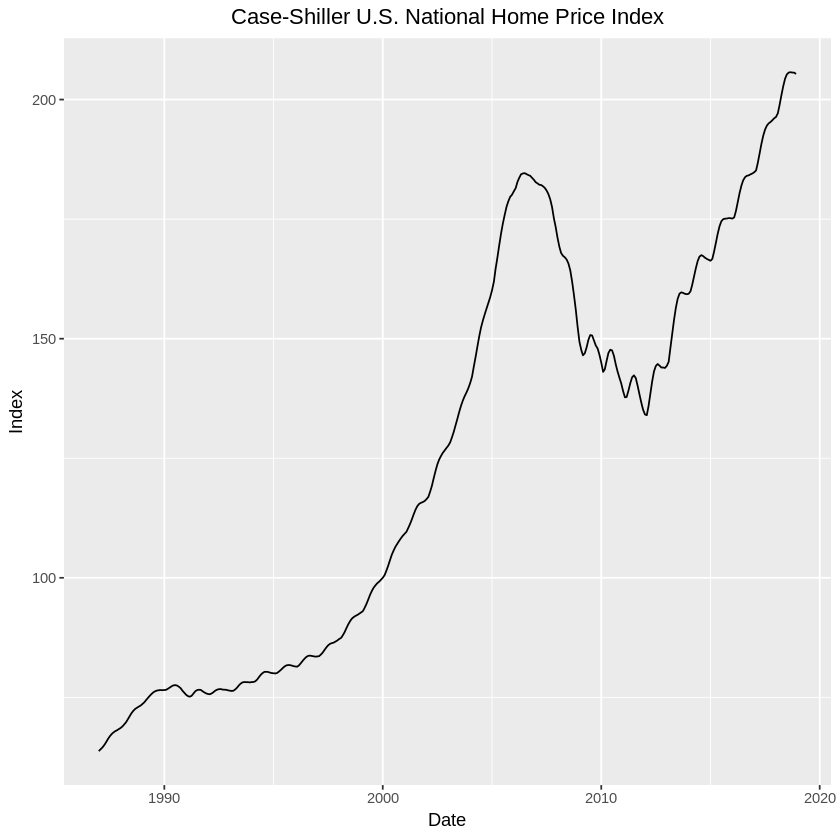

In [81]:
ggplot(HomePrice, aes(Index)) + 
    geom_line(aes(y = HomePrice$CSUSHPINSA))+
    ggtitle("Case-Shiller U.S. National Home Price Index") +
    labs(x = "Date", y = "Index") + 
    theme(plot.title = element_text(hjust = 0.5))

In [113]:
# Perform adf test with time series of HomePrice
# See https://stackoverflow.com/questions/16447461/adf-test-returning-p-0-99-with-xts-but-returning-p-0-01-with-coredataxts
# Null Hypothesis - Unit root is present
# Alternative Hypothesis - Stationary

# At 1% significance level, we cannot reject the null hypothesis that an unit root is present.
# The series is likely to have an unit root and is not stationary

adf.test(as.ts(HomePrice))


	Augmented Dickey-Fuller Test

data:  as.ts(HomePrice)
Dickey-Fuller = -2.3903, Lag order = 7, p-value = 0.4123
alternative hypothesis: stationary


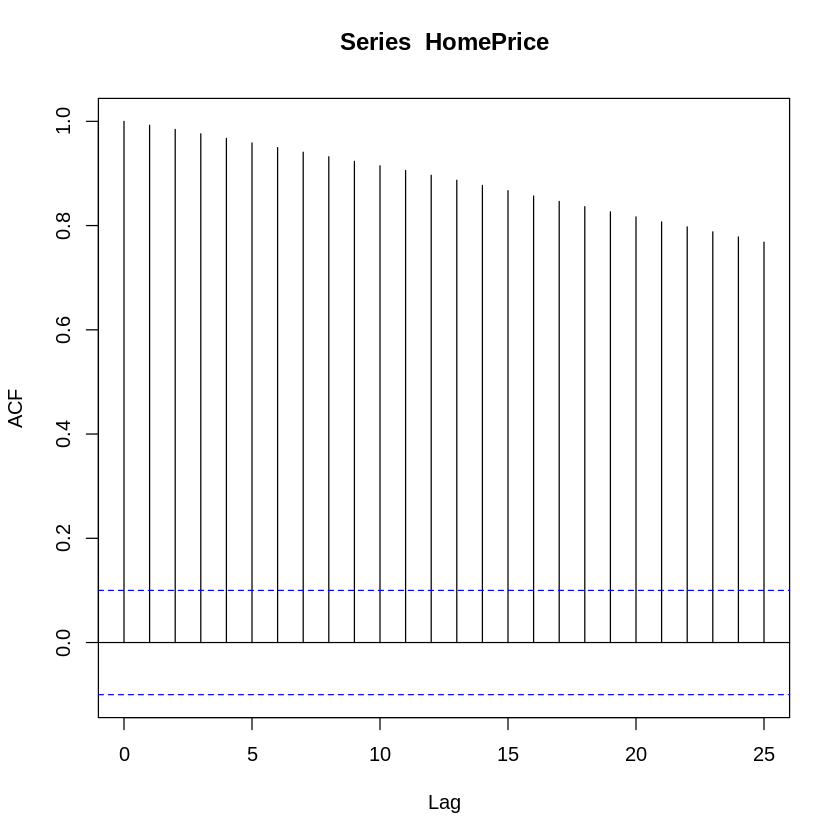

In [114]:
# Plot ACF for HomePrice
acf(HomePrice)

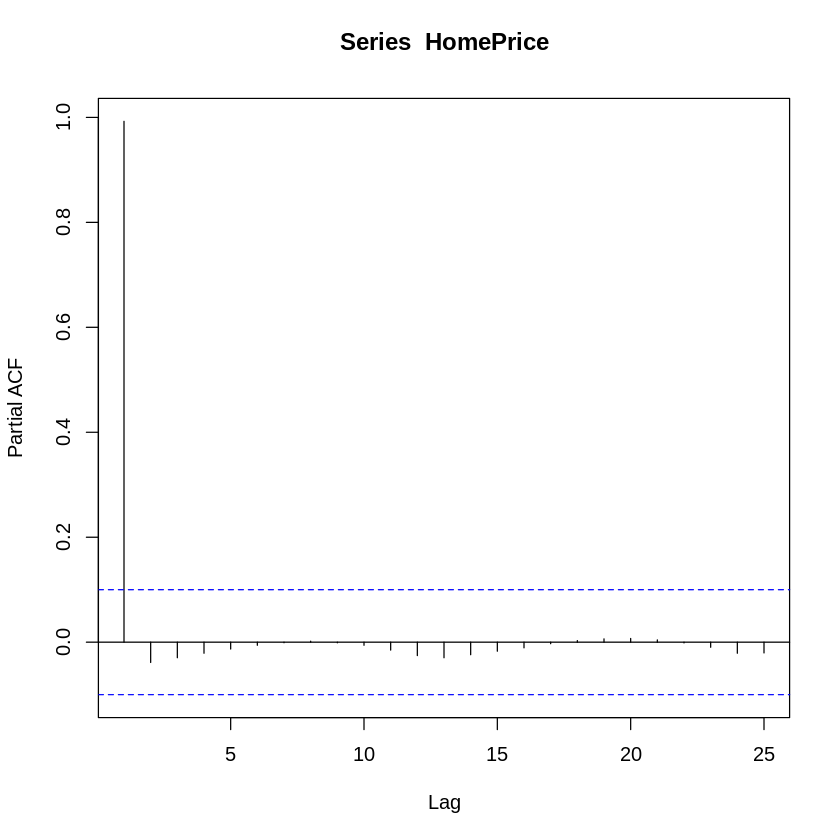

In [115]:
# Plot PACF for HomePrice
pacf(HomePrice)

In [195]:
# Applying difference
differenced = diff(HomePrice, differences = 1)
differenced = differenced[2:nrow(differenced)]

In [196]:
adf.test(as.ts(differenced))


	Augmented Dickey-Fuller Test

data:  as.ts(differenced)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


In [230]:
# Applying difference
differenced = diff(HomePrice, differences = 1)
differenced = differenced[2:nrow(differenced)]

In [231]:
adf.test(as.ts(differenced))


	Augmented Dickey-Fuller Test

data:  as.ts(differenced)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


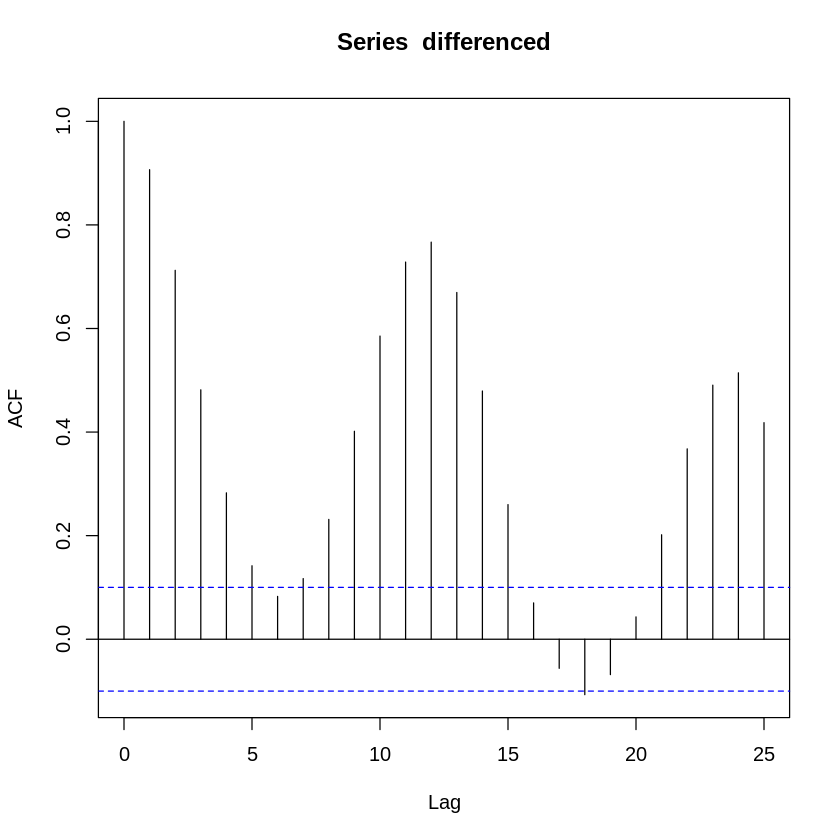

In [232]:
# Plot ACF for HomePrice
acf(differenced)

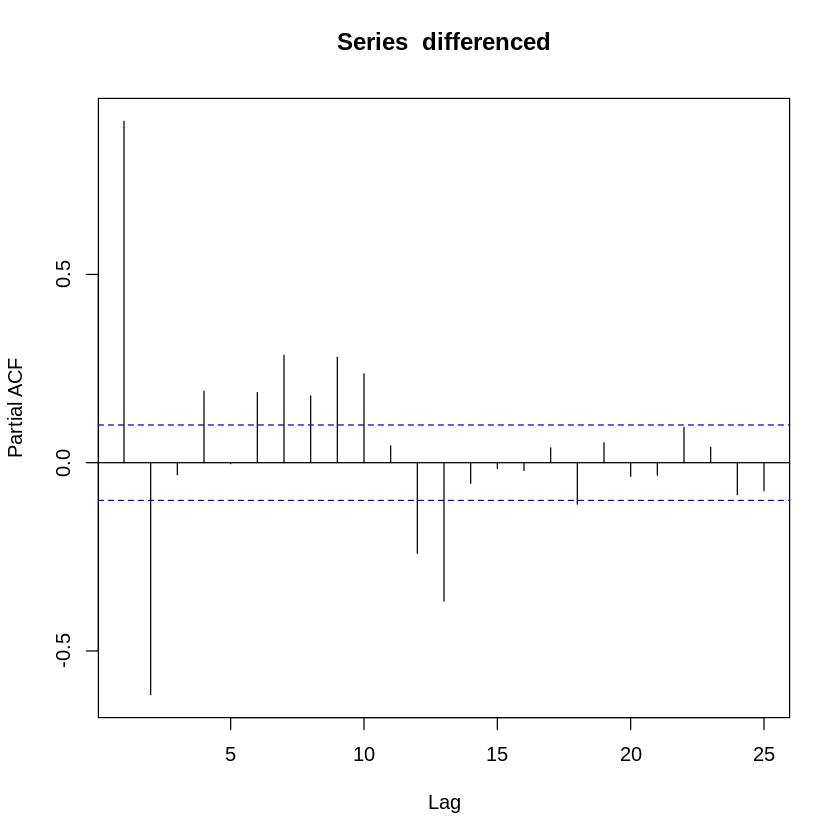

In [233]:
# Plot ACF for HomePrice
pacf(differenced)

In [234]:
ARIMA_model <- arima(window(differenced), order=c(0,1,0), method = "ML")
ARIMA_model
summary(ARIMA_model)
Box.test(ARIMA_model$residuals, lag = 1)


Call:
arima(x = window(differenced), order = c(0, 1, 0), method = "ML")


sigma^2 estimated as 0.1703:  log likelihood = -203.9,  aic = 409.79

          Length Class  Mode     
coef        0    -none- numeric  
sigma2      1    -none- numeric  
var.coef    0    -none- numeric  
mask        0    -none- logical  
loglik      1    -none- numeric  
aic         1    -none- numeric  
arma        7    -none- numeric  
residuals 383    ts     numeric  
call        4    -none- call     
series      1    -none- character
code        1    -none- numeric  
n.cond      1    -none- numeric  
nobs        1    -none- numeric  
model      10    -none- list     


	Box-Pierce test

data:  ARIMA_model$residuals
X-squared = 114.57, df = 1, p-value < 2.2e-16


In [235]:
ARIMA_model <- arima(window(HomePrice), order=c(0,2,0), method = "ML")
ARIMA_model
summary(ARIMA_model)
Box.test(ARIMA_model$residuals, lag = 1)


Call:
arima(x = window(HomePrice), order = c(0, 2, 0), method = "ML")


sigma^2 estimated as 0.1703:  log likelihood = -203.9,  aic = 409.79

          Length Class  Mode     
coef        0    -none- numeric  
sigma2      1    -none- numeric  
var.coef    0    -none- numeric  
mask        0    -none- logical  
loglik      1    -none- numeric  
aic         1    -none- numeric  
arma        7    -none- numeric  
residuals 384    ts     numeric  
call        4    -none- call     
series      1    -none- character
code        1    -none- numeric  
n.cond      1    -none- numeric  
nobs        1    -none- numeric  
model      10    -none- list     


	Box-Pierce test

data:  ARIMA_model$residuals
X-squared = 114.86, df = 1, p-value < 2.2e-16


In [263]:
tail(HomePrice[1:280])

           CSUSHPINSA
2009-11-01    147.947
2009-12-01    146.676
2010-01-01    145.003
2010-02-01    143.057
2010-03-01    143.596
2010-04-01    145.396

In [268]:
AR_forecast$pred

Time Series:
Start = 281 
End = 352 
Frequency = 1 
 [1] 147.196 148.996 150.796 152.596 154.396 156.196 157.996 159.796 161.596
[10] 163.396 165.196 166.996 168.796 170.596 172.396 174.196 175.996 177.796
[19] 179.596 181.396 183.196 184.996 186.796 188.596 190.396 192.196 193.996
[28] 195.796 197.596 199.396 201.196 202.996 204.796 206.596 208.396 210.196
[37] 211.996 213.796 215.596 217.396 219.196 220.996 222.796 224.596 226.396
[46] 228.196 229.996 231.796 233.596 235.396 237.196 238.996 240.796 242.596
[55] 244.396 246.196 247.996 249.796 251.596 253.396 255.196 256.996 258.796
[64] 260.596 262.396 264.196 265.996 267.796 269.596 271.396 273.196 274.996

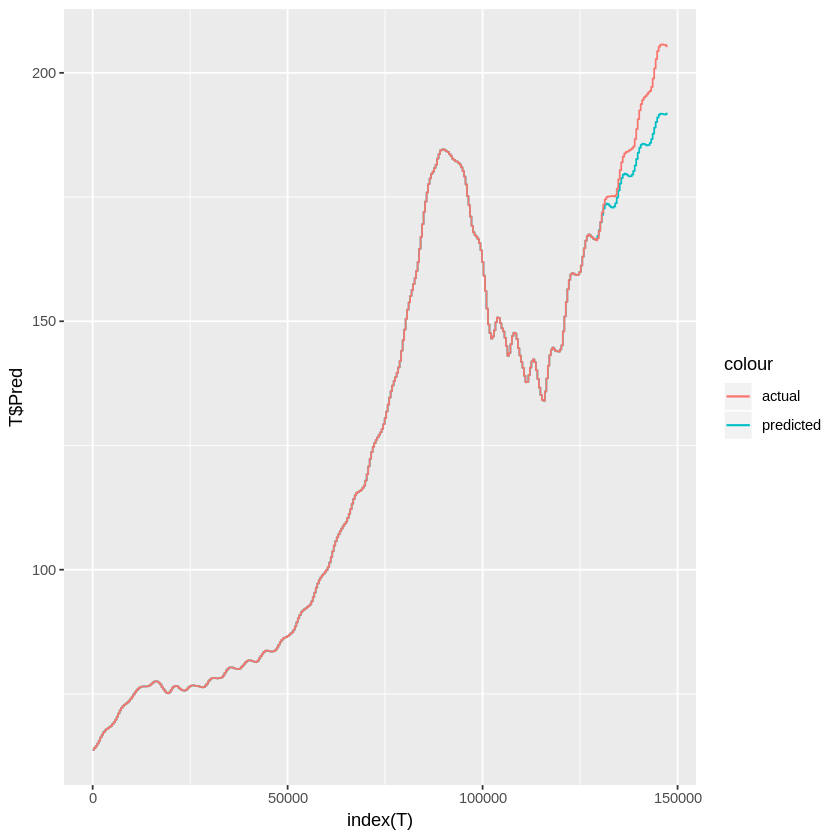

In [527]:
periodToForecast = 50
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(12,2,0), method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

HomePriceWPrediction = HomePrice
HomePriceWPrediction$Pred = NA

for(i in 1:trainPeriod) {
    HomePriceWPrediction$Pred[i] = HomePriceWPrediction$CSUSHPINSA[i]
}
for(i in 1:periodToForecast) {
    HomePriceWPrediction$Pred[trainPeriod+i] = predictions$pred[i]
}


# X

T = merge(index(HomePriceWPrediction),coredata(HomePriceWPrediction))
#T[1]
ggplot(T, aes(index(T))) + 
    geom_line(aes(y = T$Pred, color="predicted")) +
    geom_line(aes(y = T$CSUSHPINSA, color="actual"))



Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


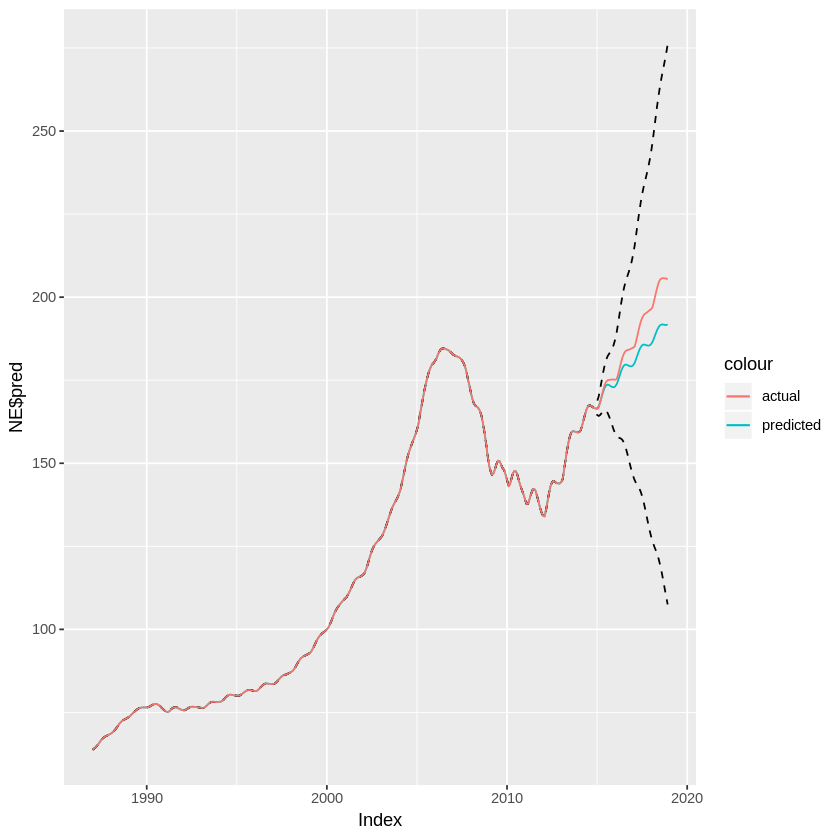

In [530]:
periodToForecast = 50
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(12,2,0), method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePriceWPrediction$CSUSHPINSA[i]
        upper[i] = HomePriceWPrediction$CSUSHPINSA[i]
        lower[i] = HomePriceWPrediction$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}

NE = merge(HomePrice, pred, upper, lower)

ggplot(NE, aes(Index)) + 
    geom_line(aes(y = NE$pred, color="predicted")) +
    geom_line(aes(y = NE$upper), linetype="dashed") +
    geom_line(aes(y = NE$lower), , linetype="dashed") +
    geom_line(aes(y = NE$CSUSHPINSA, color="actual"))

In [278]:
ARIMA_model <- arima(HomePrice, order=c(0,2,0), method = "ML")
AR_forecast <- predict(ARIMA_model,n.ahead= 72,se.fit=TRUE)
AR_forecast$pred
com = merge(HomePrice, AR_forecast$pred)

Time Series:
Start = 385 
End = 456 
Frequency = 1 
 [1] 205.068 204.784 204.500 204.216 203.932 203.648 203.364 203.080 202.796
[10] 202.512 202.228 201.944 201.660 201.376 201.092 200.808 200.524 200.240
[19] 199.956 199.672 199.388 199.104 198.820 198.536 198.252 197.968 197.684
[28] 197.400 197.116 196.832 196.548 196.264 195.980 195.696 195.412 195.128
[37] 194.844 194.560 194.276 193.992 193.708 193.424 193.140 192.856 192.572
[46] 192.288 192.004 191.720 191.436 191.152 190.868 190.584 190.300 190.016
[55] 189.732 189.448 189.164 188.880 188.596 188.312 188.028 187.744 187.460
[64] 187.176 186.892 186.608 186.324 186.040 185.756 185.472 185.188 184.904

In [239]:
ARIMA_model <- arima(window(HomePrice), order=c(1,2,0), method = "ML")
ARIMA_model
summary(ARIMA_model)
Box.test(ARIMA_model$residuals, lag = 1)


Call:
arima(x = window(HomePrice), order = c(1, 2, 0), method = "ML")

Coefficients:
         ar1
      0.5461
s.e.  0.0427

sigma^2 estimated as 0.1193:  log likelihood = -136.09,  aic = 276.18

          Length Class  Mode     
coef        1    -none- numeric  
sigma2      1    -none- numeric  
var.coef    1    -none- numeric  
mask        1    -none- logical  
loglik      1    -none- numeric  
aic         1    -none- numeric  
arma        7    -none- numeric  
residuals 384    ts     numeric  
call        4    -none- call     
series      1    -none- character
code        1    -none- numeric  
n.cond      1    -none- numeric  
nobs        1    -none- numeric  
model      10    -none- list     


	Box-Pierce test

data:  ARIMA_model$residuals
X-squared = 2.6238, df = 1, p-value = 0.1053


In [248]:
ARIMA_model <- arima(window(HomePrice), order=c(12,1,2), method = "ML")
ARIMA_model
summary(ARIMA_model)
Box.test(ARIMA_model$residuals, lag = 1)


Call:
arima(x = window(HomePrice), order = c(12, 1, 2), method = "ML")

Coefficients:
         ar1      ar2     ar3     ar4      ar5     ar6     ar7      ar8     ar9
      1.9705  -1.4785  0.3229  0.4008  -0.3713  0.0031  0.2060  -0.1521  0.0163
s.e.  0.0975   0.1943  0.1735  0.1378   0.1447  0.1411  0.1381   0.1403  0.1368
        ar10    ar11     ar12      ma1     ma2
      0.0269  0.3269  -0.2930  -0.8581  0.3573
s.e.  0.1362  0.1265   0.0597   0.0977  0.0918

sigma^2 estimated as 0.05731:  log likelihood = 0.1,  aic = 29.79


Call:
arima(x = window(HomePrice), order = c(12, 1, 2), method = "ML")

Coefficients:
         ar1      ar2     ar3     ar4      ar5     ar6     ar7      ar8     ar9
      1.9705  -1.4785  0.3229  0.4008  -0.3713  0.0031  0.2060  -0.1521  0.0163
s.e.  0.0975   0.1943  0.1735  0.1378   0.1447  0.1411  0.1381   0.1403  0.1368
        ar10    ar11     ar12      ma1     ma2
      0.0269  0.3269  -0.2930  -0.8581  0.3573
s.e.  0.1362  0.1265   0.0597   0.0977  0.0918

sigma^2 estimated as 0.05731:  log likelihood = 0.1,  aic = 29.79

Training set error measures:
                     ME      RMSE       MAE        MPE      MAPE      MASE
Training set 0.01616611 0.2391144 0.1495516 0.01583488 0.1124072 0.2009898
                    ACF1
Training set -0.01717412



	Box-Pierce test

data:  ARIMA_model$residuals
X-squared = 0.11326, df = 1, p-value = 0.7365


In [270]:
library(forecast)
auto.arima(HomePrice)

Series: HomePrice 
ARIMA(3,1,2) with drift 

Coefficients:
         ar1     ar2      ar3     ma1     ma2   drift
      0.8691  0.1006  -0.2271  0.6108  0.2862  0.3638
s.e.  0.1461  0.2174   0.1142  0.1429  0.0816  0.1156

sigma^2 estimated as 0.09685:  log likelihood=-94.77
AIC=203.54   AICc=203.84   BIC=231.18

In [250]:
auto.arima(HomePrice)

Series: HomePrice 
ARIMA(3,1,2) with drift 

Coefficients:
         ar1     ar2      ar3     ma1     ma2   drift
      0.8691  0.1006  -0.2271  0.6108  0.2862  0.3638
s.e.  0.1461  0.2174   0.1142  0.1429  0.0816  0.1156

sigma^2 estimated as 0.09685:  log likelihood=-94.77
AIC=203.54   AICc=203.84   BIC=231.18

In [271]:
arima.forecast = forecast.Arima(fit, h = 1,level=99)


ERROR: Error in forecast.Arima(fit, h = 1, level = 99): could not find function "forecast.Arima"


In [394]:
?plot